# Masking the Data
Placing a limit on the frequency may help you achieve an optimal result in the fitting process.

Even on a good dataset, we can get a sizable error if we take into consideration every single frequency of data. This is because there can be some data that is considered an outlier. Take for example, 'DE_40_1_30.mpt' which by all accounts, is a good dataset without any unusual spikes or drops in the data. Let's take a look at if we were to import all frequencies in the file.

In [1]:
#Locate the data, prepare for import of the MPT file
#Import necessary packaging
from utils.tools import *
path=r"C:\Users\cjang\Desktop\\"
data = ['DE_40_1_30.mpt']
ex_mpt = mpt_data(path,data)

No handles with labels found to put in legend.


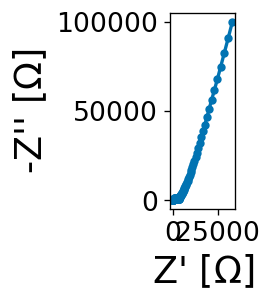

In [2]:
ex_mpt.mpt_plot()

In [3]:
ex_mpt.df_raw['re']

0         54.048367
1         63.989281
2         74.258514
3         84.547234
4         94.702721
           ...     
115    24918.471000
116    26710.168000
117    28695.117000
118    30874.131000
119    33241.840000
Name: re, Length: 120, dtype: float64

If we take the guessing iterator and run it on this dataset, the guessing iterator has to find a fitting equation that satisfies every single point on this set, or something that is close.

Because the iterator cut out at 100 iterations and return the set of coefficients at that state, we cannot say with full confidence that this is the best fit because it didn't necessarily satisfy the threshold. If we graph this 'optimal' set of coefficients, we aren't guaranteed a great fitting graph...

What we can do is eliminate some of the frequencies from the file to make it easier to get a more accurate graph. But how do we determine which frequencies to drop from the file? 

# Masking Functions

There are a number of methods in order to achieve a mask, but the truth is, there isn't a single method to find a perfect mask for every single mpt file. For efficiency, I implemented a couple masks(masker, masker0, fastmask) that vary in algorithm, but have been moderately successful in finding a good fit for the files that have been tested on. Finally, I implemented a window masker, where one can examine the graph, determine a window, and pick the values in that window to fit on. 

In [4]:
ex_mpt.fast_mask()

[1000018.6, 63.082302]

In [5]:
#Notice how the graph shows log(f) not f. We must translate back
#so instead of 1.75 and 6, we must insert 10**1.75 and 10**6
masked_mpt = mpt_data(path,data, mask = [1000018.6, 63.082302])
#masked_mpt.guesser(Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2)

No handles with labels found to put in legend.


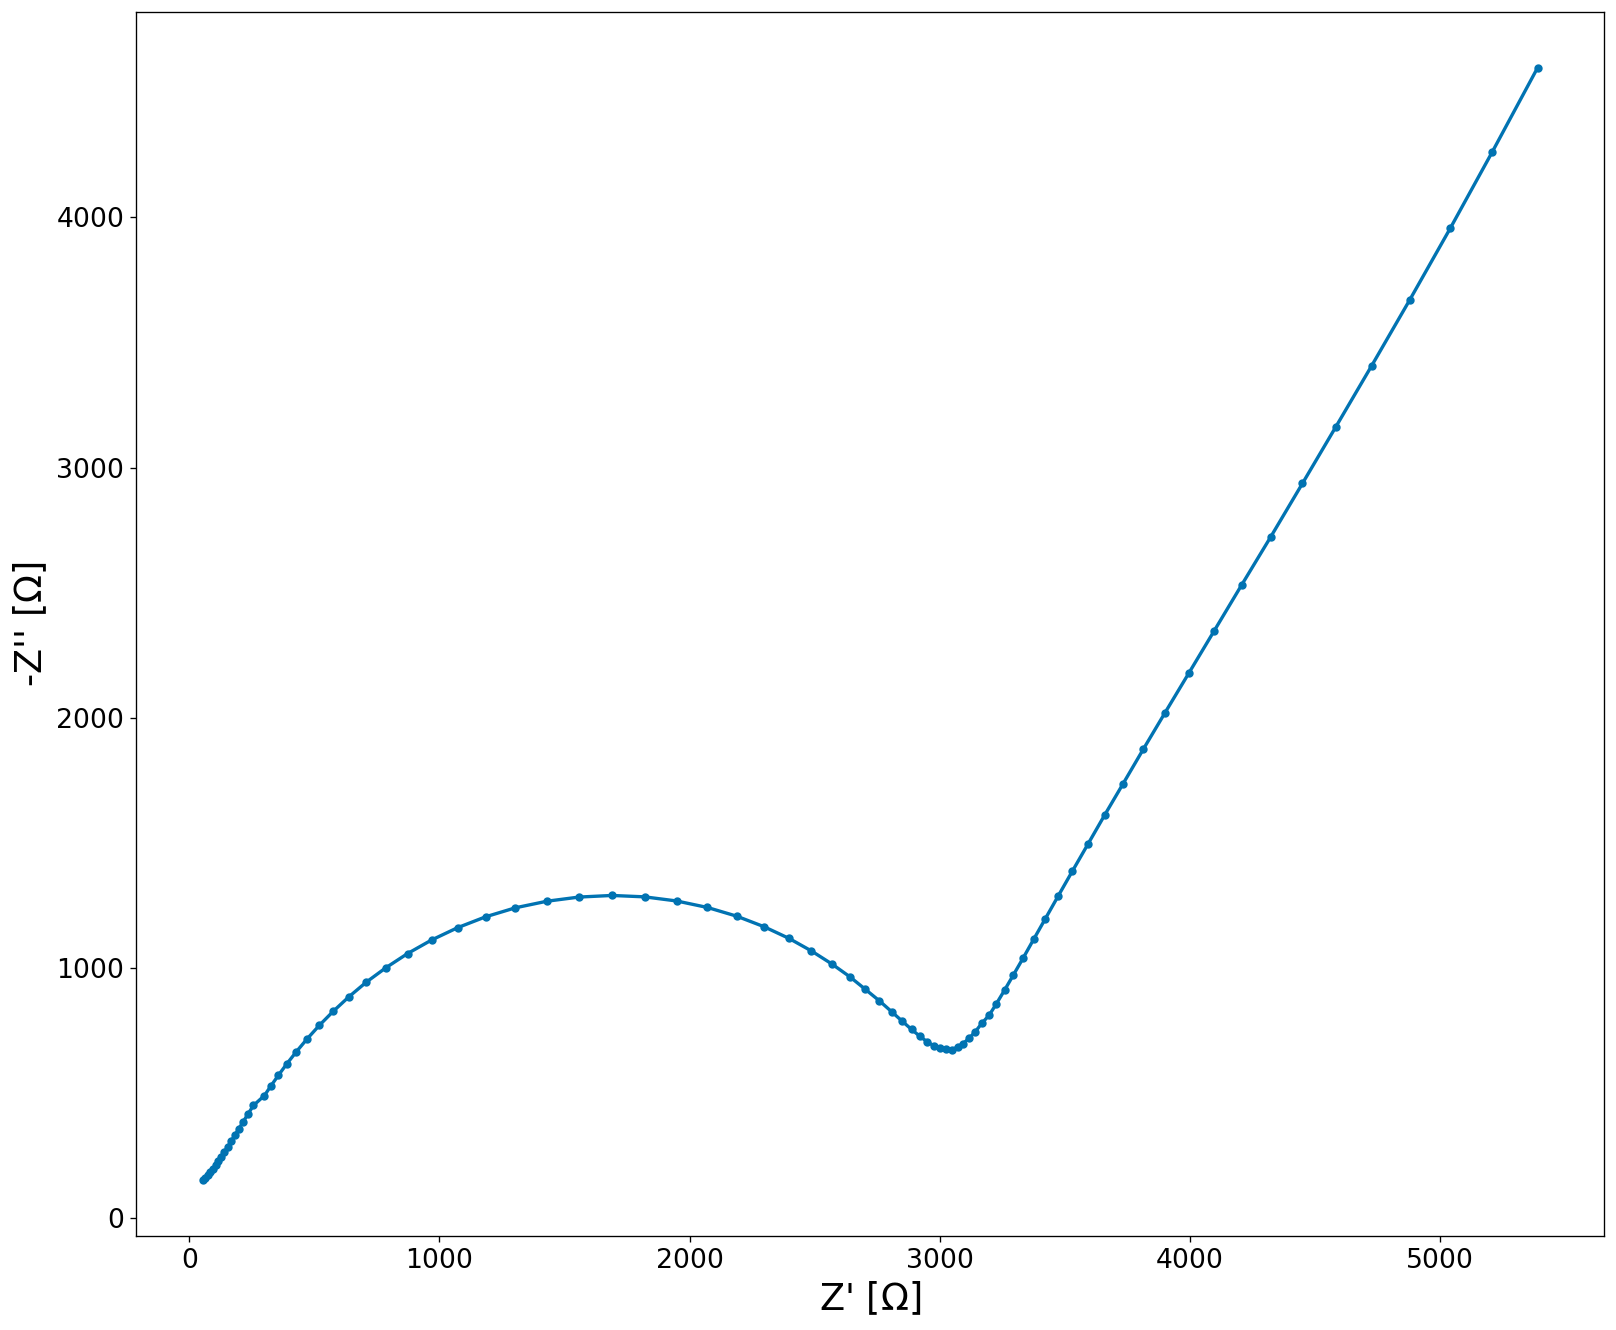

In [6]:
masked_mpt.set_new_gph_dims(30,30)
masked_mpt.mpt_plot()

This is a much better picture than in the previous pages. We can now run a fitting function on this and see the results are going to be a lot better.

In [7]:
masked_mpt.guesser()

42992186
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.6488694558
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.51539570524
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.6556283985
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.6948408097
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.43696640676
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.66109004046
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.639034705
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.65401791444
MPT FILE :  DE_40_1_30.mpt  ERROR:  371830.65642992186
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.96492731397
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.9573668258
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.8238930949
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.9641258088
MPT FILE :  DE_40_1_30.mpt  ERROR:  371828.0033364617
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.7454670033
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.96958741394
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.94753229426
MPT FILE :  DE_40_1_30.mpt  ERROR:  371827.967016231
MPT FILE :  D

IndexError: list index out of range

No handles with labels found to put in legend.


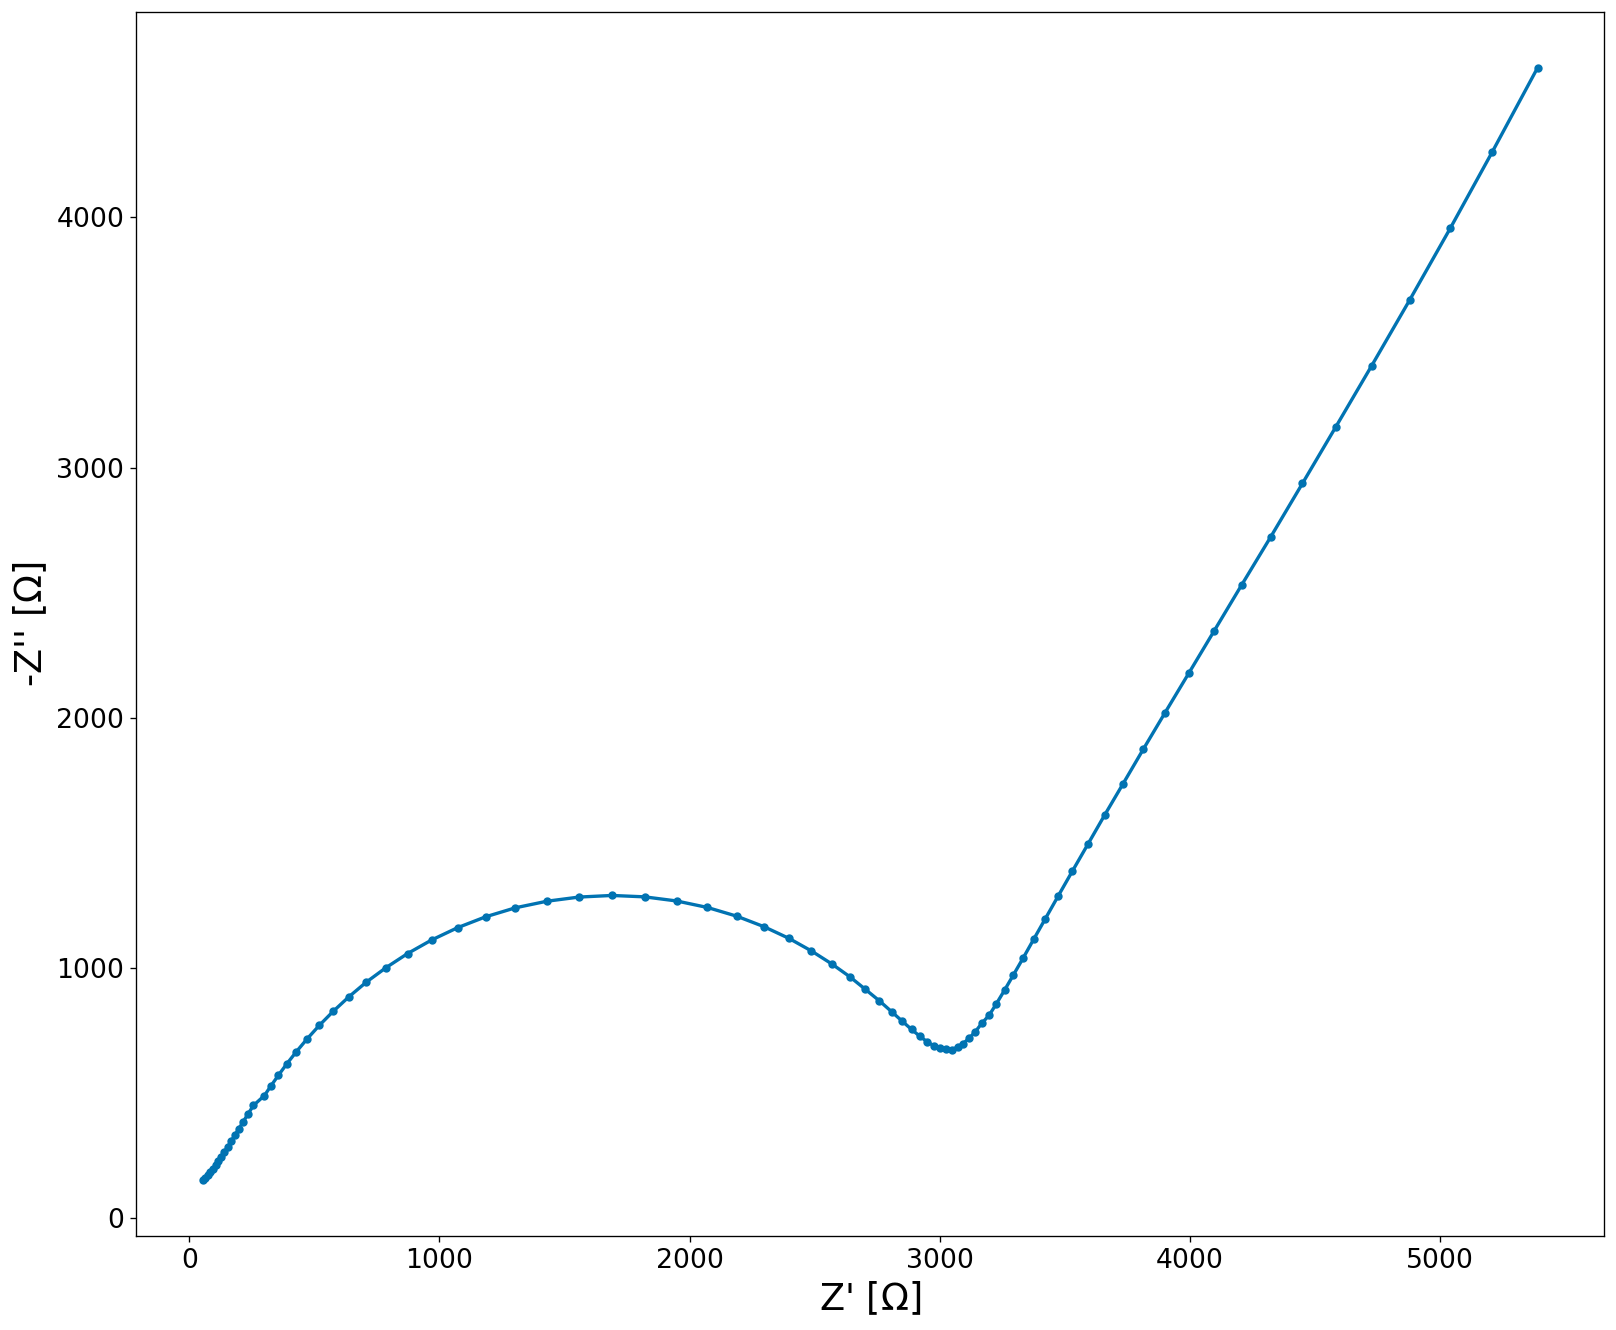

In [10]:
masked_mpt.mpt_plot()


We can see that this operation still takes too much time. If time is not an issue, we can leave the function running and see the results afterwards. However, if we want a faster time, we can customize the window so that we only deal with the highest frequencies. All the masking functions are essentially methods to try and capture that high frequency window.

No handles with labels found to put in legend.


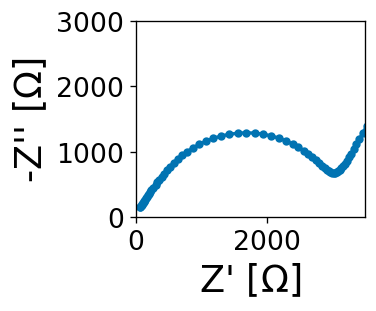

In [11]:
ex_mpt.mpt_plot(x_window=[0,3500], y_window = [0,3000])

This seems like a fair window, lets use this one.

In [12]:
#Find the frequencies that lie inside that window
ex_mpt.window_masker(x_window = [0,3500], y_window = [0,3000])

[1000018.6, 446.85895]

No handles with labels found to put in legend.


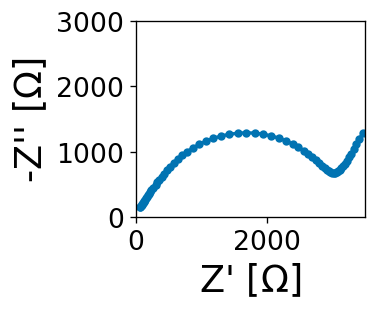

In [13]:
window_masked_data = mpt_data(path,data, mask = [1000018.6, 446.85895])
window_masked_data.mpt_plot(x_window = [0,3500], y_window = [0,3000])
#To verify our window

In [14]:
window_masked_data.guesser()

 DE_40_1_30.mpt  ERROR:  2385087.5177790546
MPT FILE :  DE_40_1_30.mpt  ERROR:  2596027.5907195173
MPT FILE :  DE_40_1_30.mpt  ERROR:  4087667.823199285
MPT FILE :  DE_40_1_30.mpt  ERROR:  132845.17222386424
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 136
    # variables        = 9
    chi-square         = 91.7373165
    reduced chi-square = 0.72234107
    Akaike info crit   = -35.5466882
    Bayesian info crit = -9.33279423
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
    n3:   at initial value
    fs3:  at initial value
    fs3:  at boundary
[[Variables]]
    Rs:   27.5572121 (init = 27.55721)
    R:    3201.63816 (init = 3201.638)
    n:    0.82063290 (init = 0.8206329)
    fs:   20903.9677 (init = 20903.97)
 

,file,fit_R,fit_Rs,fit_n,fit_Q,fit_R2,fit_n2,fit_Q2,fit_n3,fit_Q3
0,DE_40_1_30.mpt,27.557212,3201.638156,0.820633,1.969216e-08,35738.385282,0.90218,6.677026e-07,0.950169,0.019563


No handles with labels found to put in legend.


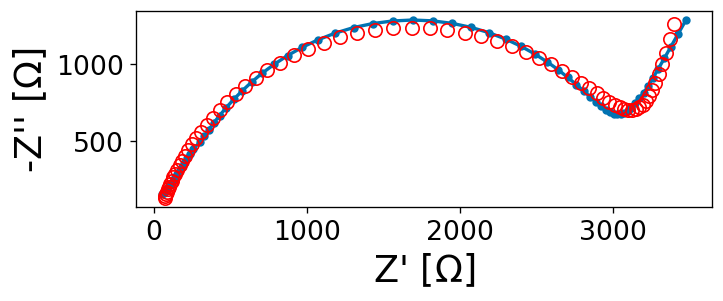

In [15]:
window_masked_data.mpt_plot(fitting = 'on')